In [1]:
# Ignoring warnings.
import warnings

warnings.filterwarnings('ignore')
# Imports, as always...

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.utils import produce_reduced_embeddings, silhouette
from scripts import models

# Measuring convergence.
from sklearn.decomposition import KernelPCA

# Beautification.
sns.set_context('paper')
sns.set_style('dark')
sns.set_palette('Set2')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set RNG.
torch.manual_seed(42)

# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
).to(device)

print(dataset.data)

# Settings shared across all models.
n_nodes = dataset.data.x.size(0)
model_depths = [5, 10, 20]
aggregation_function = GCNConv
hid_dim = 64
dropout_ratio = .1
act_fn = F.relu

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# Convergence

This notebook explores the convergence property of GNN architectures with differing residual connection methods, as trained in `training.ipynb` and defined in `./scripts/`.

## Loading Trained Models

In [9]:
# Instantiating models of the correct architectural designs.
def instantiate_models():
    none_models = [
        models.BackboneModel(
            residual_method=None,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ] 
    fixed_models = [
        models.BackboneModel(
            residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    free_models = [
        models.BackboneModel(
            residual_method=models.FreeRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    hierarchical_models = [
        models.BackboneModel(
            residual_method=models.HierarchicalRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    cluster_models = [
        models.BackboneModel(
            residual_method=models.ClusterKeepingRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn,
            L_0=2 # Give an extra layer before cluster keeping.
        ).to(device)
        for depth in model_depths
    ]
    
    return none_models, fixed_models, free_models, hierarchical_models, cluster_models

none_models, fixed_models, free_models, hierarchical_models, cluster_models = instantiate_models()

In [10]:
def load_state_dicts():
    for model in none_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/none_{depth}.pt'))   
        
    # Too big to push to repo.
    for model in fixed_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/fixed_{depth}.pt'))   
        
    # Too big to push to repo.
    for model in free_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/free_{depth}.pt'))   
    
    # Too big to push to repo.
    for model in hierarchical_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/hierarchical_{depth}.pt'))   
        
    for model in cluster_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/cluster_{depth}.pt'))   
  
# Takes ~16s
load_state_dicts()

## Master Convergence Plot

In [11]:
# Generate the reduced features for each model at each depth (takes ~18s).
none_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in none_models
}
fixed_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in fixed_models
}
free_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in free_models
}
hierarchical_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in hierarchical_models
}
cluster_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in cluster_models
}

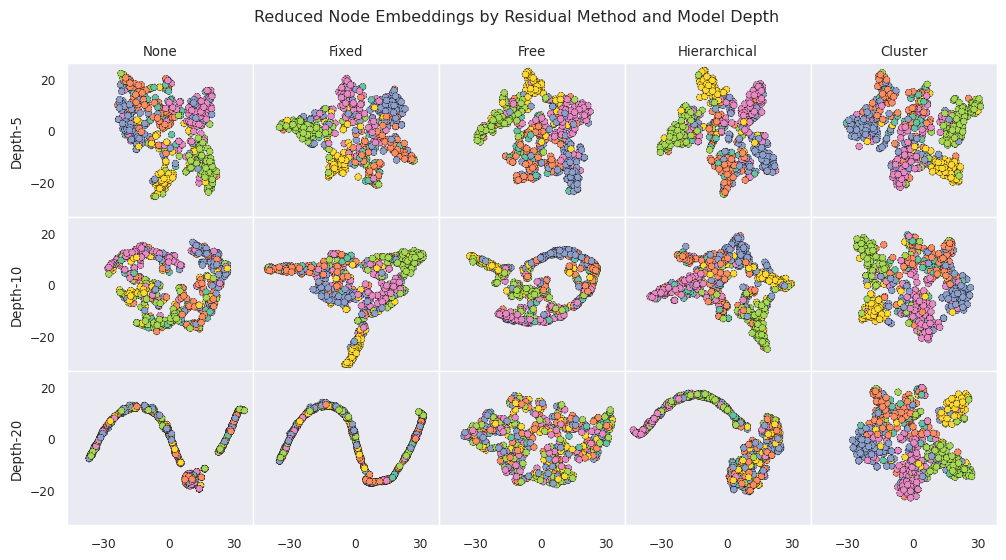

In [15]:
def draw_scatterplot(feature_df, ax):
    return sns.scatterplot(
        # Plot points and colour them.
        x=feature_df['dimension 1'],
        y=feature_df['dimension 2'],
        hue=feature_df['labels'],
        ax=ax,

        # Beautification.
        palette='Set2',
        linestyle='--',
        edgecolors='k'
    )

def draw_master_convergence_plot(save=True):
    # Put all subplots on the same axes scales.
    fig, axes = plt.subplots(3, 5, figsize=(12, 6), sharex='all', sharey='all')
    
    for row, depth in enumerate(model_depths):
        draw_scatterplot(none_reduced_features_by_depth[depth], axes[row][0])
        draw_scatterplot(fixed_reduced_features_by_depth[depth], axes[row][1])
        draw_scatterplot(free_reduced_features_by_depth[depth], axes[row][2])
        draw_scatterplot(hierarchical_reduced_features_by_depth[depth], axes[row][3])
        draw_scatterplot(cluster_reduced_features_by_depth[depth], axes[row][4])
        
    # Remove clutter.
    [[axes[i][j].legend([], [], frameon=False) for i in range(3)] for j in range(5)]
    [[axes[i][j].set_xlabel('') for i in range(3)] for j in range(5)]
    [[axes[i][j].set_xticks([-30, 0, 30]) for i in range(3)] for j in range(5)]
    [[axes[i][j].set_ylabel('') for i in range(3)] for j in range(5)]
    [[axes[i][j].set_yticks([-20, 0, 20]) for i in range(3)] for j in range(5)]
    
    # Add titles.
    [axes[0][i].set_title(['None', 'Fixed', 'Free', 'Hierarchical', 'Cluster'][i]) for i in range(5)]
    [axes[i][0].set_ylabel(f'Depth-{model_depths[i]}') for i in range(3)]
    
    fig.suptitle('Reduced Node Embeddings by Residual Method and Model Depth', y=.97)
        
    # Save figure.
    plt.subplots_adjust(wspace=0, hspace=0)
    if save:
        plt.savefig('./figures/convergence/master.pdf', bbox_inches='tight')
    
draw_master_convergence_plot(True)

## Quantifying Convergence

We would like a nice numerical method to quantify how "converged" a graph has become. Intuitively, this method will be a function of the *spread of node representations*. There are a boat-load of metrics to choose from that do this:
- **Variance**, straight-forwardly measuring the variance of node representations around a centroid (i.e. graph-level representation);
- **Cosine similarity**, measuring the alignment of node representations;
- **Euclidean distance**, measuring the distance between nodes in the representation space; etc.

Spectral analysis may provide the most powerful way to measure convergence of nodes in the representation space. Again, there are different ways to do this.

In [3]:
def produce_embeddings(model: torch.nn.Module, data: torch_geometric.data.data.Data, mask: torch.Tensor) -> np.ndarray:
    # Into evaluation mode.
    model.eval()

    # Generate node embeddings (as a numpy array).
    embeddings = model.generate_node_embeddings(data.x, data.edge_index)[mask]
    return embeddings.detach().cpu().numpy()

def compute_svd_entropy(embeddings: np.ndarray) -> float:
    # SVD.
    singular_values = np.linalg.svd(embeddings).S
    
    # Normalise and compute entropy.
    normalised_singular_values = singular_values / sum(singular_values)
    return - sum(normalised_singular_values * np.log(normalised_singular_values))

def compute_svd_contributions(embeddings: np.ndarray, n_values: int) -> float:
    # SVD.
    singular_values = np.linalg.svd(embeddings).S
    
    # Normalise and compute contributions.
    normalised_singular_values = singular_values / sum(singular_values)
    return sum(normalised_singular_values[:n_values])

def compute_distances_from_centroid(embeddings: np.ndarray, dist_method : str = 'Euclidean') -> np.ndarray:
    # Pool (e.g. mean pooling) to compute a graph-level representation (i.e. a centroid).
    centroid = np.mean(embeddings, axis=0)
    
    # Specify the distance method.
    def dist_fn(x, y):
        if dist_method == 'Cosine':
            return 1 - (np.dot(x, y) / np.linalg.norm(x) * np.linalg.norm(y))
        
        return np.linalg.norm(x - y)

    # For every datapoint, compute the "distance" to centroid.
    return np.apply_along_axis(lambda x: dist_fn(x, centroid), 1, embeddings)

In [18]:
def get_stats(gnn_dict, *stat_tuples) -> pd.DataFrame:
    stats_df = pd.DataFrame(columns=['Model', 'Depth'] + [stat[1] for stat in stat_tuples])
    
    for model_title, model_list in gnn_dict.items():
        for model in model_list:
            embeddings = produce_embeddings(model, dataset.data, dataset.data.val_mask)
            
            row = {'Model': model_title, 'Depth': model.n_layers}
            for stat_fn, stat_title in stat_tuples:
                row[stat_title] = stat_fn(embeddings)
                
            stats_df = pd.concat([stats_df, pd.DataFrame([row])], ignore_index=True)
    
    return stats_df.reset_index().drop(columns=['index'])
        
gnn_dict = {'None': none_models, 'Fixed': fixed_models, 'Free': free_models, 'Hierarchical': hierarchical_models, 'Cluster': cluster_models}
        
get_stats(
    gnn_dict,
    (compute_svd_entropy, 'SVD Entropy'), 
    (lambda xs: compute_svd_contributions(xs, 3), 'SVD Contributions (3)')
)

,Model,Depth,SVD Entropy,SVD Contributions (3),Mean Dist. to Centroid,Std. Dist. to Centroid
0,None,5,1.455891,0.814516,8.083910,4.573116
1,None,10,1.423859,0.843783,21.736917,12.789797
2,None,20,0.014054,0.999840,0.031435,0.036021
3,Fixed,5,1.067360,0.881366,4.054338,2.393820
4,Fixed,10,1.000127,0.922427,13.147422,14.023001
5,Fixed,20,0.008562,0.999940,0.018724,0.021733
6,Free,5,1.245743,0.860769,4.636421,3.055259
7,Free,10,1.078152,0.922967,19.546867,18.886467
8,Free,20,0.025377,0.999198,0.045486,0.033434
9,Hierarchical,5,1.040862,0.878146,2.794512,1.415516


### More Detail

In [164]:
def analyse_convergence_by_depth(residual_method, residual_name, depths):
    # Define and load weights.
    gnns = [
        models.BackboneModel(
            residual_method=residual_method,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in depths
    ] 
    [gnn.load_state_dict(torch.load(f'./models/gcn/{residual_name.lower()}_{gnn.n_layers}.pt')) for gnn in gnns]
        
    # Get convergence stats.
    convergence_stats = get_stats(
        {residual_name: gnns},
        (compute_svd_entropy, 'SVD Entropy'), 
        (lambda xs: compute_svd_contributions(xs, 3), 'SVD Contributions (3)')
    )
    
    return convergence_stats

In [165]:
none_convergence_stats = analyse_convergence_by_depth(
    residual_method=None,
    residual_name='None',
    depths=range(1, 21)
)

In [168]:
fixed_convergence_stats = analyse_convergence_by_depth(
    residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
    residual_name='Fixed',
    depths=range(1, 21)
)

In [169]:
free_convergence_stats = analyse_convergence_by_depth(
    residual_method=models.FreeRC,
    residual_name='Free',
    depths=range(1, 21)
)

In [170]:
joined_convergence_stats = pd.concat([none_convergence_stats, fixed_convergence_stats, free_convergence_stats])
joined_convergence_stats

,Model,Depth,SVD Entropy,SVD Contributions (3)
0,None,1,1.200562,0.824937
1,None,2,1.191358,0.847637
2,None,3,1.216395,0.845684
3,None,4,1.269370,0.832313
4,None,5,1.455891,0.814516
5,None,6,1.420168,0.847115
6,None,7,1.490962,0.831287
7,None,8,1.464208,0.830000
8,None,9,1.448428,0.847227
9,None,10,1.423859,0.843783


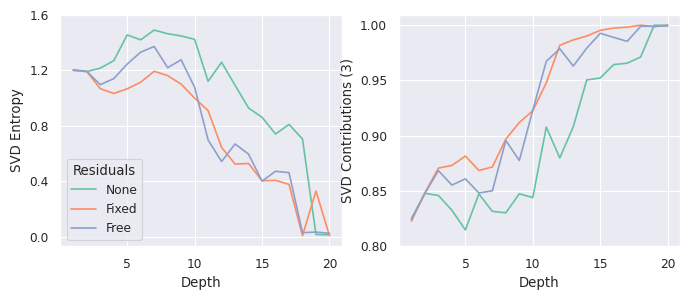

In [171]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')

sns.lineplot(data=joined_convergence_stats, x='Depth', y='SVD Entropy', hue='Model', ax=axes[0])
sns.lineplot(data=joined_convergence_stats, x='Depth', y='SVD Contributions (3)', hue='Model', ax=axes[1])

axes[0].set_yticks([.0, .4, .8, 1.2, 1.6])
axes[1].set_yticks([.8, .85, .9, .95, 1.])

axes[0].legend(loc='lower left', title='Residuals')
axes[1].legend([], [], frameon=False)

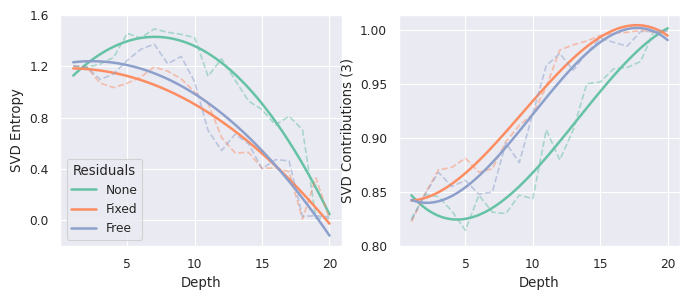

In [172]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')
colours = sns.color_palette('Set2', 3)

# Entropies.
sns.regplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Entropy'], 
    order=2,
    color=colours[0], 
    scatter=False,
    ci=None,
    ax=axes[0], label='None'
)
sns.lineplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Entropy'], 
    color=colours[0], 
    linestyle='--',
    alpha=.5,
    ax=axes[0]
)
sns.regplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Entropy'], 
    order=2,
    color=colours[1], 
    scatter=False,
    ci=None,
    ax=axes[0], label='Fixed'
)
sns.lineplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Entropy'], 
    color=colours[1], 
    linestyle='--',
    alpha=.5,
    ax=axes[0]
)
sns.regplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Entropy'], 
    order=2,
    color=colours[2], 
    scatter=False,
    ci=None,
    ax=axes[0], label='Free'
)
sns.lineplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Entropy'], 
    color=colours[2], 
    linestyle='--',
    alpha=.5,
    ax=axes[0]
)

# Contributions.
sns.regplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Contributions (3)'], 
    order=3,
    color=colours[0], 
    scatter=False,
    ci=None,
    ax=axes[1], label='None'
)
sns.lineplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Contributions (3)'], 
    color=colours[0], 
    linestyle='--',
    alpha=.5,
    ax=axes[1]
)
sns.regplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Contributions (3)'], 
    order=3,
    color=colours[1], 
    scatter=False,
    ci=None,
    ax=axes[1], label='Fixed'
)
sns.lineplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Contributions (3)'], 
    color=colours[1], 
    linestyle='--',
    alpha=.5,
    ax=axes[1]
)
sns.regplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Contributions (3)'], 
    order=3,
    color=colours[2], 
    scatter=False,
    ci=None,
    ax=axes[1], label='Free'
)
sns.lineplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Contributions (3)'], 
    color=colours[2], 
    linestyle='--',
    alpha=.5,
    ax=axes[1]
)


axes[0].set_yticks([.0, .4, .8, 1.2, 1.6])
axes[1].set_yticks([.8, .85, .9, .95, 1.])

axes[0].legend(loc='lower left', title='Residuals')
axes[1].legend([], [], frameon=False)

SVD is not able to quantify what we can intuitively see to be the case through the reduced embedding visualisations! Clearly, the embedding representations are inherently nonlinear, and so SVD cannot be used. 

We then need a nonlinear method! We can try **Kernel PCA**.

In [2]:
bad_model = models.BackboneModel(
    residual_method=None,
    aggregation_function=aggregation_function,
    n_nodes=n_nodes,
    input_dim=dataset.num_features,
    hid_dim=hid_dim,
    n_classes=dataset.num_classes,
    n_layers=20,
    dropout_ratio=dropout_ratio,
    act_fn=act_fn,
).to(device)
bad_model.load_state_dict(torch.load('./models/gcn/none_20.pt'))

good_model = models.BackboneModel(
    residual_method=models.ClusterKeepingRC,
    aggregation_function=aggregation_function,
    n_nodes=n_nodes,
    input_dim=dataset.num_features,
    hid_dim=hid_dim,
    n_classes=dataset.num_classes,
    n_layers=20,
    dropout_ratio=dropout_ratio,
    act_fn=act_fn,
    L_0=2
).to(device)
good_model.load_state_dict(torch.load('./models/gcn/cluster_20.pt'))

<All keys matched successfully>

In [3]:
def compute_kernal_PCA_stats(model: nn.Module, data, mask, out_dim=None):
    # Into evaluation mode.
    model.eval()
    
    # Generate embeddings and reduce them via Kernel PCA
    embeddings = model.generate_node_embeddings(data.x, data.edge_index)[mask].detach().cpu().numpy()
    transformer = KernelPCA(n_components=out_dim, kernel='rbf')
    reduced_embeddings = transformer.fit_transform(embeddings)
    
    # Get the eigenvalues.
    eigenvalues = transformer.eigenvalues_
    
    # Normalise the eigenvalues so that we can see contribution in each principal component.
    contributions = abs(eigenvalues) / sum(eigenvalues)
    
    # Entropy calculation.
    return - sum(contributions * np.log(contributions)), contributions

for model in [good_model, bad_model]:
    entropy, contributions = compute_kernal_PCA_stats(model, dataset.data, dataset.data.val_mask, out_dim=10)
    print(entropy)
    print(contributions)
    print()

1.7866027541458607
[0.2929868  0.24349044 0.18910974 0.1204858  0.06939526 0.04031777
 0.01356003 0.01257015 0.00923857 0.00884547]

0.14236046350561082
[9.7751498e-01 1.0923438e-02 5.4032383e-03 1.8525583e-03 1.1076776e-03
 9.2276308e-04 7.7142427e-04 5.8626116e-04 5.0704775e-04 4.1054896e-04]


We can see that a good model spreads the variance of its node embeddings across many principal components, which also serves to increase the overall entropy. On the other hand, a bad model converges its node embeddings such that the vast majority of the variance focuses into a single principal component, which then greatly reduces the overall entropy.

In [4]:
# Computing the stats across all models at all depths.
def compute_kernel_PCA_stats_all_models(depths, data, mask, out_dim=10):
    # Defining a list of tuples (residual method, name to print).
    residuals = [
        (None, 'None'),
        (lambda *args: models.FixedRC(torch.tensor([1/2] * n_nodes), *args), 'Fixed'),
        (models.FreeRC, 'Free'),
        (models.HierarchicalRC, 'Hierarchical'),
        (models.ClusterKeepingRC, 'Cluster')
    ]
    
    # Instantiate a DataFrame to hold the data.
    # We will have a column for the proportion of variance contributed by each principal component, as well as an overall entropy column.
    df = pd.DataFrame(columns=['Residual', 'Depth', 'Entropy'] + [f'Var. Contr. by {i+1}' for i in range(out_dim)])
    
    for depth in tqdm(depths):
        for residual_method, residual_name in residuals:
            # Instantiate and load that model at that depth.
            model = models.BackboneModel(
                residual_method=residual_method,
                aggregation_function=aggregation_function,
                n_nodes=n_nodes,
                input_dim=dataset.num_features,
                hid_dim=hid_dim,
                n_classes=dataset.num_classes,
                n_layers=depth,
                dropout_ratio=dropout_ratio,
                act_fn=act_fn,
                L_0=2 if residual_name == 'Cluster' else 1
            ).to(device)
            model.load_state_dict(torch.load(f'./models/gcn/{residual_name.lower()}_{depth}.pt'))
            
            # Compute the stats and append them to the dataframe.
            entropy, contributions = compute_kernal_PCA_stats(model, data, mask, out_dim)
            df.loc[len] = [residual_name, depth, entropy] + list(contributions)
            
    return df

In [5]:
kernel_pca_stats = compute_kernel_PCA_stats_all_models(range(1, 21), dataset.data, dataset.data.val_mask, out_dim=10)

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
kernel_pca_stats['Depth'] = kernel_pca_stats['Depth'].astype(int)
kernel_pca_stats

,Residual,Depth,Entropy,Var. Contr. by 1,Var. Contr. by 2,Var. Contr. by 3,Var. Contr. by 4,Var. Contr. by 5,Var. Contr. by 6,Var. Contr. by 7,Var. Contr. by 8,Var. Contr. by 9,Var. Contr. by 10
0,None,1,1.982934,0.264997,0.183775,0.144596,0.131237,0.111253,0.077703,0.025433,0.022889,0.020142,0.017975
1,Fixed,1,1.989713,0.260828,0.179236,0.143734,0.133377,0.116487,0.079441,0.025713,0.023575,0.019251,0.018357
2,Free,1,1.985719,0.263524,0.180396,0.147884,0.131797,0.111965,0.077472,0.025222,0.023339,0.019987,0.018415
3,Hierarchical,1,1.981013,0.265733,0.185507,0.140409,0.129137,0.113460,0.081104,0.024618,0.022623,0.019789,0.017620
4,Cluster,1,1.985052,0.266659,0.173780,0.145606,0.133935,0.116833,0.076863,0.024690,0.023054,0.019903,0.018679
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,None,20,0.142361,0.977515,0.010923,0.005403,0.001853,0.001108,0.000923,0.000771,0.000586,0.000507,0.000410
96,Fixed,20,0.214127,0.964807,0.012740,0.009249,0.004420,0.002422,0.001999,0.001373,0.001174,0.000947,0.000867
97,Free,20,0.638988,0.806186,0.154449,0.025283,0.004733,0.003306,0.002427,0.001576,0.000868,0.000669,0.000501
98,Hierarchical,20,1.255773,0.612398,0.202031,0.068356,0.043075,0.024459,0.018256,0.012224,0.008736,0.006950,0.003514


In [8]:
kernel_pca_stats.to_csv('./data/convergence_stats.csv')

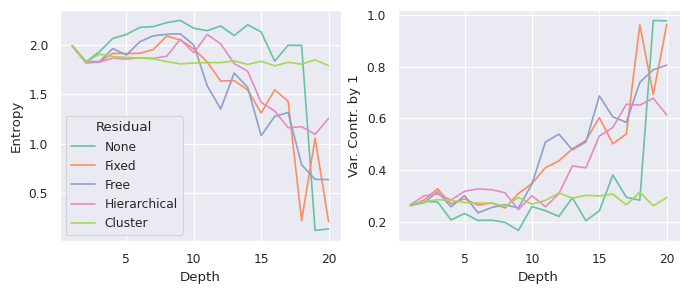

In [7]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')

sns.lineplot(data=kernel_pca_stats, x='Depth', y='Entropy', hue='Residual', ax=axes[0])
sns.lineplot(data=kernel_pca_stats, x='Depth', y='Var. Contr. by 1', hue='Residual', ax=axes[1])

axes[1].set_yticks(np.arange(.2, 1.1, step=.2))
axes[1].legend([], [], frameon=False)

Text(0.5, 0.98, 'Quantifying Convergence by Depth')

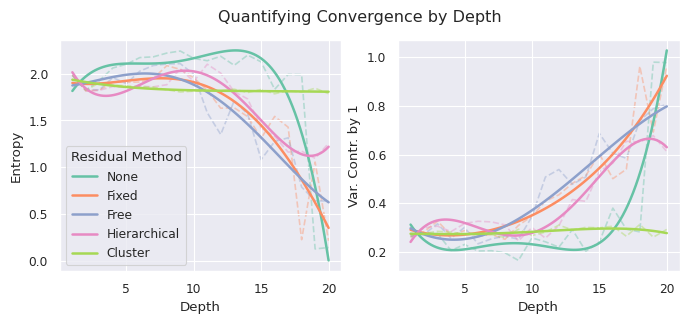

In [9]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')
colours = sns.color_palette('Set2', n_colors=5)

[sns.regplot(data=kernel_pca_stats[kernel_pca_stats['Residual'] == residual_method], x='Depth', y='Entropy', ax=axes[0], color=colours[i], scatter=False, order=4, ci=None, label=residual_method) for i, residual_method in enumerate(kernel_pca_stats['Residual'].unique())]
sns.lineplot(data=kernel_pca_stats, x='Depth', y='Entropy', hue='Residual', ax=axes[0], linestyle='--', alpha=.4, zorder=-1)
axes[0].legend(kernel_pca_stats['Residual'].unique(), title='Residual Method')

[sns.regplot(data=kernel_pca_stats[kernel_pca_stats['Residual'] == residual_method], x='Depth', y='Var. Contr. by 1', ax=axes[1], color=colours[i], scatter=False, order=4, ci=None, label=residual_method) for i, residual_method in enumerate(kernel_pca_stats['Residual'].unique())]
sns.lineplot(data=kernel_pca_stats, x='Depth', y='Var. Contr. by 1', hue='Residual', ax=axes[1], linestyle='--', alpha=.4, zorder=-1)
axes[1].legend([], [], frameon=False)

axes[1].set_yticks(np.arange(.2, 1.1, step=.2))
fig.suptitle('Quantifying Convergence by Depth')

#fig.savefig('./figures/convergence/quantified-convergence-by-depth.pdf', bbox_inches='tight')

## Quantifying 'Cluster Mixing'

Next, we would like a way to measure how "mixed" the classes are in the node embeddings to understand the extent of the *semantic* over-smoothing problem.

Some ideas to measure "mixedness":
- Look at each node's $k$ nearest neighbours and compute the proportion that have the same label. We could even plot a Voronoi tesselation to show the inter-mingling of label neighbourhoods.
- Computing the pairwise distances between the centroids of each class; higher distances imply the classes are more physically separated in space.

We will use **silhouette scores** (see [here](https://www.sciencedirect.com/science/article/pii/0377042787901257?via%3Dihub)). Recall that this idea is integrated within the cluster-keeping residual connections, so we would expect these models to perform well with regard to this metric.

### Computing Silhouette Scores

We could compute the silhouette score just as we did in the `compute_silhouette_coefficient` method of `models.ClusterKeepingRC` to compute the coefficient in each node, then aggregate in some way (e.g. averaging, sum).

In [10]:
def compute_silhouette_coefficient(H, ys, centroids, i):
    H_i = H[ys[i]]
    H_js = H[ys == ys[i]]

    # Average distance from the i-th node to the other nodes in its assigned cluster.
    a_i = torch.mean(torch.linalg.norm(H_js - H_i, dim=1))

    # Distance to the next nearest cluster (i.e. NOT its own cluster).
    # The paper considers the average distance to every node in a cluster to calculate this.
    # That is absurdly expensive, so we'll just consider centroids.
    other_cluster_indices = list(range(ys[i])) + list(range(ys[i]+1, dataset.num_classes))
    b_i = torch.mean(torch.linalg.norm(centroids[other_cluster_indices] - H_i,  dim=1))

    return (b_i - a_i) / max(a_i, b_i)

def compute_silhouette_score(model, data, mask, reduce='mean'):
    # Into evaluation mode.
    model.eval()
    
    # Generate embeddings.
    embeddings = model.generate_node_embeddings(data.x, data.edge_index)
    
    # Compute class centroids.
    centroids = torch.stack([embeddings[data.y == class_id].mean(dim=0) for class_id in data.y.unique().sort().values])
    
    # Compute silhouette coefficients.
    silhouette_coefficients = torch.tensor([
        compute_silhouette_coefficient(embeddings, data.y, centroids, i)
        for i in range(n_nodes) if mask[i]
    ])
    
    # Aggregate.
    if reduce == 'mean':
        return torch.mean(silhouette_coefficients).item()
    else:
        return silhouette_coefficients.detach().cpu().numpy()

In [11]:
compute_silhouette_score(good_model, dataset.data, dataset.data.val_mask), compute_silhouette_score(bad_model, dataset.data, dataset.data.val_mask)

(-0.09496786445379257, -0.6922121047973633)

In [19]:
def compute_kernel_silhouette_stats_all_models(depths, data, mask):
    # Defining a list of tuples (residual method, name to print).
    residuals = [
        (None, 'None'),
        (lambda *args: models.FixedRC(torch.tensor([1/2] * n_nodes), *args), 'Fixed'),
        (models.FreeRC, 'Free'),
        (models.HierarchicalRC, 'Hierarchical'),
        (models.ClusterKeepingRC, 'Cluster')
    ]
    
    # Instantiate a DataFrame to hold the data.
    # We will have a column for the proportion of variance contributed by each principal component, as well as an overall entropy column.
    df = pd.DataFrame(columns=['Residual', 'Depth', 'Sum Silhouette', 'Sum Absolute Silhouette', 'Mean Silhouette', 'Mean Absolute Silhouette'])
    
    for depth in tqdm(depths):
        for residual_method, residual_name in residuals:
            # Instantiate and load that model at that depth.
            model = models.BackboneModel(
                residual_method=residual_method,
                aggregation_function=aggregation_function,
                n_nodes=n_nodes,
                input_dim=dataset.num_features,
                hid_dim=hid_dim,
                n_classes=dataset.num_classes,
                n_layers=depth,
                dropout_ratio=dropout_ratio,
                act_fn=act_fn,
                L_0=2 if residual_name == 'Cluster' else 1
            ).to(device)
            model.load_state_dict(torch.load(f'./models/gcn/{residual_name.lower()}_{depth}.pt'))
            
            # Compute the stats and append them to the dataframe.
            silhouette_scores = compute_silhouette_score(model, data, mask, reduce=None)
            df.loc[len] = [residual_name, depth, silhouette_scores.sum(), silhouette_scores.__abs__().sum(), silhouette_scores.mean(), silhouette_scores.__abs__().mean()]
            
    return df

In [20]:
silhouette_stats = compute_kernel_silhouette_stats_all_models(range(1, 21), dataset.data, dataset.data.val_mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
silhouette_stats['Depth'] = silhouette_stats['Depth'].astype(int)
silhouette_stats

,Residual,Depth,Sum Silhouette,Sum Absolute Silhouette,Mean Silhouette,Mean Absolute Silhouette
0,None,1,-29.402241,59.364609,-0.058804,0.118729
1,Fixed,1,-31.212181,60.749565,-0.062424,0.121499
2,Free,1,-32.068043,60.734806,-0.064136,0.121470
3,Hierarchical,1,-29.040386,60.343277,-0.058081,0.120687
4,Cluster,1,-32.011341,60.767105,-0.064023,0.121534
...,...,...,...,...,...,...
95,None,20,-346.106323,346.106323,-0.692213,0.692213
96,Fixed,20,-348.667236,348.667236,-0.697334,0.697334
97,Free,20,-175.995743,175.995743,-0.351991,0.351991
98,Hierarchical,20,112.911728,314.067017,0.225823,0.628134


In [22]:
silhouette_stats.to_csv('./data/silhouette_stats.csv')

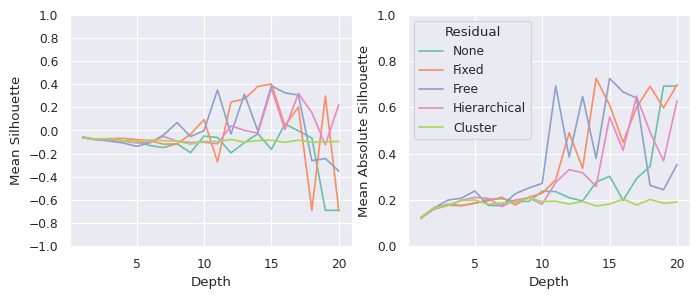

In [23]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')

sns.lineplot(data=silhouette_stats, x='Depth', y='Mean Silhouette', hue='Residual', ax=axes[0])
sns.lineplot(data=silhouette_stats, x='Depth', y='Mean Absolute Silhouette', hue='Residual', ax=axes[1])

axes[0].set_yticks(np.arange(-1., 1.1, step=.2))
axes[1].set_yticks(np.arange(.0, 1.1, step=.2))
axes[0].legend([], [], frameon=False)

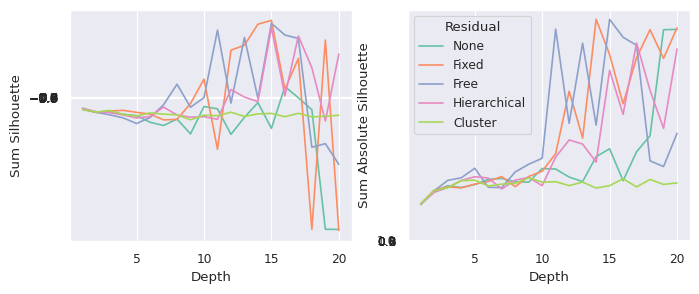

In [24]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')

sns.lineplot(data=silhouette_stats, x='Depth', y='Sum Silhouette', hue='Residual', ax=axes[0])
sns.lineplot(data=silhouette_stats, x='Depth', y='Sum Absolute Silhouette', hue='Residual', ax=axes[1])

axes[0].set_yticks(np.arange(-1., 1.1, step=.2))
axes[1].set_yticks(np.arange(.0, 1.1, step=.2))
axes[0].legend([], [], frameon=False)

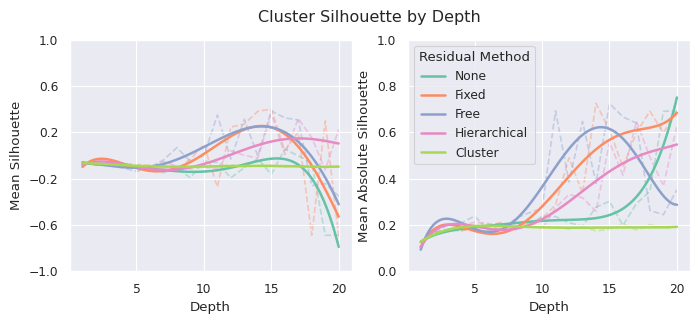

In [37]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')
colours = sns.color_palette('Set2', n_colors=5)

[sns.regplot(data=silhouette_stats[silhouette_stats['Residual'] == residual_method], x='Depth', y='Mean Silhouette', ax=axes[0], color=colours[i], scatter=False, order=5, ci=None, label=residual_method) for i, residual_method in enumerate(silhouette_stats['Residual'].unique())]
sns.lineplot(data=silhouette_stats, x='Depth', y='Mean Silhouette', hue='Residual', ax=axes[0], linestyle='--', alpha=.4, zorder=-1)
axes[0].legend([], [], frameon=False)

[sns.regplot(data=silhouette_stats[silhouette_stats['Residual'] == residual_method], x='Depth', y='Mean Absolute Silhouette', ax=axes[1], color=colours[i], scatter=False, order=5, ci=None, label=residual_method) for i, residual_method in enumerate(silhouette_stats['Residual'].unique())]
sns.lineplot(data=silhouette_stats, x='Depth', y='Mean Absolute Silhouette', hue='Residual', ax=axes[1], linestyle='--', alpha=.4, zorder=-1)
axes[1].legend(silhouette_stats['Residual'].unique(), title='Residual Method')

axes[0].set_yticks(np.arange(-1., 1.1, step=.4))
axes[1].set_yticks(np.arange(.0, 1.1, step=.2))
fig.suptitle('Cluster Silhouette by Depth')

fig.savefig('./figures/convergence/silhouette-by-depth.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'Cluster Silhouette by Depth')

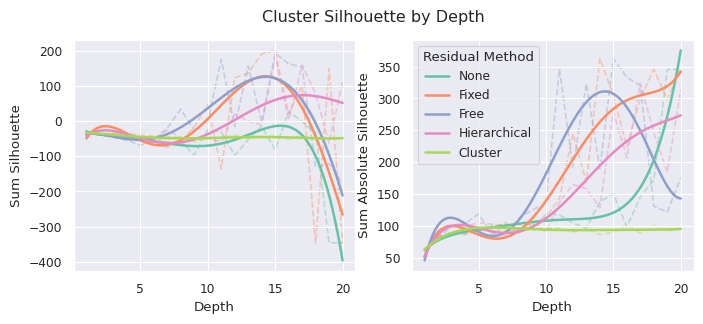

In [26]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')
colours = sns.color_palette('Set2', n_colors=5)

[sns.regplot(data=silhouette_stats[silhouette_stats['Residual'] == residual_method], x='Depth', y='Sum Silhouette', ax=axes[0], color=colours[i], scatter=False, order=5, ci=None, label=residual_method) for i, residual_method in enumerate(silhouette_stats['Residual'].unique())]
sns.lineplot(data=silhouette_stats, x='Depth', y='Sum Silhouette', hue='Residual', ax=axes[0], linestyle='--', alpha=.4, zorder=-1)
axes[0].legend([], [], frameon=False)

[sns.regplot(data=silhouette_stats[silhouette_stats['Residual'] == residual_method], x='Depth', y='Sum Absolute Silhouette', ax=axes[1], color=colours[i], scatter=False, order=5, ci=None, label=residual_method) for i, residual_method in enumerate(silhouette_stats['Residual'].unique())]
sns.lineplot(data=silhouette_stats, x='Depth', y='Sum Absolute Silhouette', hue='Residual', ax=axes[1], linestyle='--', alpha=.4, zorder=-1)
axes[1].legend(silhouette_stats['Residual'].unique(), title='Residual Method')

#axes[0].set_yticks(np.arange(-1., 1.1, step=.4))
#axes[1].set_yticks(np.arange(.0, 1.1, step=.2))
fig.suptitle('Cluster Silhouette by Depth')

#fig.savefig('./figures/convergence/silhouette-by-depth.pdf', bbox_inches='tight')

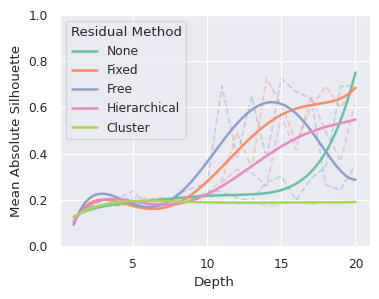

In [27]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex='all')
colours = sns.color_palette('Set2', n_colors=5)

[sns.regplot(data=silhouette_stats[silhouette_stats['Residual'] == residual_method], x='Depth', y='Mean Absolute Silhouette', ax=ax, color=colours[i], scatter=False, order=5, ci=None, label=residual_method) for i, residual_method in enumerate(silhouette_stats['Residual'].unique())]
sns.lineplot(data=silhouette_stats, x='Depth', y='Mean Absolute Silhouette', hue='Residual', ax=ax, linestyle='--', alpha=.4, zorder=-1)
ax.legend(silhouette_stats['Residual'].unique(), title='Residual Method')

ax.set_yticks(np.arange(.0, 1.1, step=.2))
#ax.set_title('Cluster Silhouette by Depth')

fig.savefig('./figures/convergence/mean-silhouette-by-depth.pdf', bbox_inches='tight')